In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import seaborn as sns
sns.set()

headers = {"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(


# Data Collection

## Target Data
Want to predict American spending on Christmas in 2023 based on data in previous years. Data collected from National Retail Federation

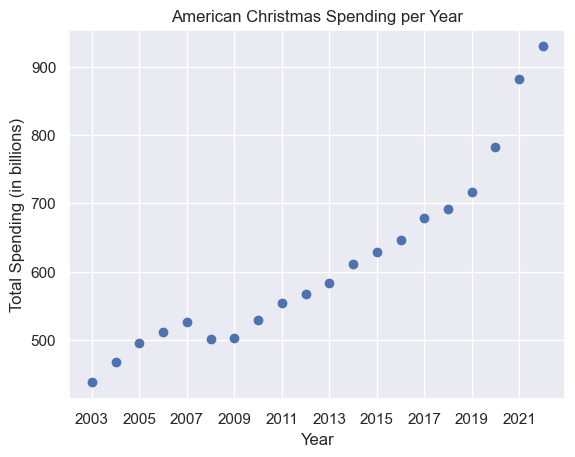

In [4]:
time = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# in billions of dollars
nrf_data = [437.6, 467.2, 496.0, 512.1, 526.0, 501.5, 502.7, 528.8, 553.3, 567.6, 583.2, 611.1, 628.0, 646.7, 678.9, 690.8, 716.9, 782.3, 881.6, 929.5]


# create initial plot of the data


plt.scatter(time, nrf_data, marker='o')

plt.xlabel('Year')
plt.ylabel('Total Spending (in billions)')
plt.title('American Christmas Spending per Year')
plt.xticks(time[::2])
plt.savefig('images/spending_over_time.png', dpi=500, bbox_inches='tight')
plt.show()

## Features

Creating features here might be a bit difficult. Here's some main ideas:

- [x] American GDP
- [x] American Population
- [x] Median income (need current year estimate) *
- [ ] Previous year's spending (note that to include this, we need to remove 2003)
- [x] Unemployment rate (nned current year estimate)
- [x] Consumer Confidence Index
- [x] Interest Rate
- [x] Inflation Rate
- [ ] Taxation (will omit for now)
- [x] Real estate market

It's also important we get the information for the current year!

### GDP

In [30]:
# US GDP (in billions) Data 2003-2022
# from https://www.macrotrends.net/countries/USA/united-states/gdp-gross-domestic-product
us_gdp = [
    11456.44,
    12217.19,
    13039.20,
    13815.59,
    14474.23,
    14769.86,
    14478.06,
    15048.96,
    15599.73,
    16253.97,
    16843.19,
    17550.68,
    18206.02,
    18695.11,
    19477.34,
    20533.06,
    21380.98,
    21060.47,
    23315.08,
    25462.70
]


# GDP for 2023 (best estimate)
# from https://www.visualcapitalist.com/visualizing-u-s-gdp-by-industry-in-2023/, 26.5

us_gdp += [26500.00]

### Population

In [31]:
# US population
# Using beautifulsoup from same website
url_pop = 'https://www.macrotrends.net/countries/USA/united-states/population'
content_pop = requests.get(url_pop, headers=headers)

In [32]:
s = BeautifulSoup(content_pop.text, 'html.parser')

# select table
a = s.find_all('table', class_='historical_data_table table table-striped table-bordered')[1]

# starts from idx 2 is 2023, idx 22 is 2003
us_pop = []

for i in range(22, 1, -1):
    us_pop.append(int(a.find_all('tr')[i].text.strip()[5:16].replace(',', '')))

In [33]:
us_pop

[293947885,
 296842670,
 299753098,
 302743399,
 305694910,
 308512035,
 311182845,
 313876608,
 316651321,
 319375166,
 322033964,
 324607776,
 327210198,
 329791231,
 332140037,
 334319671,
 335942003,
 336997624,
 338289857,
 339996563,
 341814420]

### Income

In [34]:
# US median income
# From US Social Security
url_income = 'https://www.ssa.gov/oact/cola/central.html'
content_income = requests.get(url_income, headers=headers)

In [35]:
income_soup = BeautifulSoup(content_income.text, 'html.parser')

us_med_income = []

for i in range(15, 35):
    us_med_income.append(float(income_soup.find('table').find_all('tr')[i].text.split(' ')[3].replace(',', '')))

# best estimates in this form are yet to exist, but it's safe to assume change has been in the range of 1-2k.

us_med_income += [41500]   

### Unemployment

In [36]:
# Unemployment rate
# from investopedia

url_unem = 'https://www.investopedia.com/historical-us-unemployment-rate-by-year-7495494'
content_unem = requests.get(url_unem, headers=headers)

In [37]:
unem = BeautifulSoup(content_unem.text, 'html.parser')

us_unem = []
# 2003 to 2022 occurs at 76 through 95
for i in range(76, 96):
    data = unem.find('table', class_='mntl-sc-block-table__table').find_all('tr')[i].text
    us_unem.append(float(data[6:data.find('%')]))

# from statista, best estimate for 2023 is 3.5%
    
us_unem += [3.5]

### Consumer Confidence Index

In [38]:
# from OECD
cci_df = pd.read_csv('data/DP_LIVE_26122023055003422.csv')

cci_df = cci_df[cci_df['LOCATION'] == 'USA']

cci_df['TIME'] = pd.to_datetime(cci_df['TIME'])

us_cci = cci_df[(cci_df['TIME'].dt.year >= 2003) & (cci_df['TIME'].dt.month == 11)]['Value'].values

### Interest Rate

In [39]:
# US Intrest Rate per year
# From FRED
interest_df = pd.read_csv('data/FEDFUNDS.csv')

# get things of interest
interest_df['DATE'] = pd.to_datetime(interest_df['DATE'])
filtered_interest_df = interest_df[(interest_df['DATE'].dt.year >= 2003) & (interest_df['DATE'].dt.year <= 2023) & (interest_df['DATE'].dt.month == 11) & (interest_df['DATE'].dt.day == 1)]
us_interest = filtered_interest_df['FEDFUNDS'].values

### Inflation Rate

In [56]:
# US Inflation rate
inflation_url = 'https://www.usinflationcalculator.com/inflation/current-inflation-rates/'
inflation_content = requests.get(inflation_url, headers=headers)

In [57]:
inflation_soup = BeautifulSoup(inflation_content.text, 'html.parser')

us_inflation = []
# Take November Inflation rate
for i in range(21, 0, -1):
    us_inflation.append(float(inflation_soup.find('table').find_all('tr')[i].text.split('\n')[12]))

ValueError: could not convert string to float: '\xa0'

### Real Estate

In [58]:
# Real estate information
# From FRED

re_df = pd.read_csv('data/ASPUS.csv')

re_df['DATE'] = pd.to_datetime(re_df['DATE'])

# get most recent from this year and patch from previous years
us_re = re_df[(re_df['DATE'].dt.year >= 2003) & (re_df['DATE'].dt.month == 7)]['ASPUS'].values

## EDA

In [7]:
variables = {
    'year' : np.arange(2003, 2024),
    'gdp' : us_gdp,
    'population' : us_pop,
    'unemployment_rate': us_unem,
    'interest_rate' : us_interest,
    'inflation_rate' : us_inflation,
    'real_estate_sales' : us_re
}

df = pd.read_csv('data/raw_data.csv').drop('Unnamed: 0', axis=1).iloc[:-1]
spending = pd.Series(nrf_data)


test_data = pd.read_csv('data/raw_data.csv').drop('Unnamed: 0', axis=1).iloc[[-1]]

NameError: name 'us_gdp' is not defined

In [64]:
# first, we want to standardize all feature variables

from sklearn.preprocessing import StandardScaler

features = ['gdp', 'population', 'unemployment_rate', 'interest_rate', 'inflation_rate', 'real_estate_sales']

s_training = StandardScaler()

df[features] = s_training.fit_transform(df[features])

test_data[features] = s_training.transform(test_data[features])

In [65]:
test_data[features]

,gdp,population,unemployment_rate,interest_rate,inflation_rate,real_estate_sales
20,2.520405,1.538246,-1.226427,2.397966,0.326055,2.388335


### Correlation

First, let's take a look at the correlation coefficients of each with respect to the response

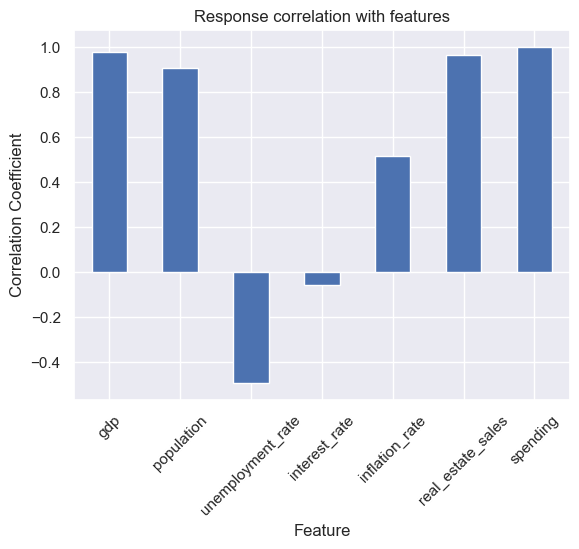

In [8]:
try:
    df
    features
    spending
except:
    spending = pd.Series(nrf_data)
    df = pd.read_csv('data/raw_data.csv').drop('Unnamed: 0', axis=1).iloc[:-1]
    features = ['gdp', 'population', 'unemployment_rate', 'interest_rate', 'inflation_rate', 'real_estate_sales']

full_df = df.copy()[features]

full_df['spending'] = spending

full_df.corr()['spending'].plot(kind='bar')

plt.xlabel('Feature')
plt.ylabel('Correlation Coefficient')
plt.title('Response correlation with features')
plt.xticks(rotation=45)
plt.savefig('images/correlation_each.png', dpi=500, bbox_inches='tight')
plt.show()

So far, it seems that GDP, Population, Inflation Rate and Real Estate Sales are most highly correlated. However, we don't want any correlation within the features, so let's find out if we should use PCA. We also want to check to see if unemployment rate, interest rate, and inflation rate can all be affected by data transformation. Let's do the latter first.

### Data Transformation

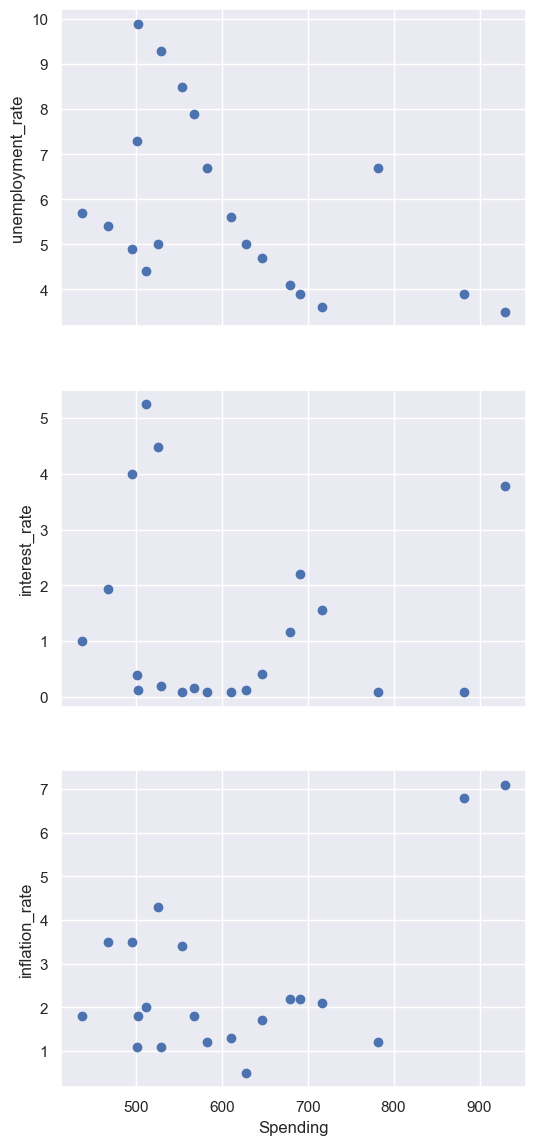

In [9]:
features_transform = ['unemployment_rate', 'interest_rate', 'inflation_rate']

fig, ax = plt.subplots(3, 1, figsize=(6, 14), sharex=True)


for i in range(3):
    ax[i].scatter(spending, df[features_transform[i]])
    ax[i].set_ylabel(features_transform[i])

plt.xlabel('Spending')
plt.show()

Luckily for me, I wrote a function that can help to figure out the best transformation of these variables!

In [10]:
from linear_exploration import product_transformations

df_tmp = df[features_transform].copy()

df_tmp['spending'] = spending


res = []

for i in range(3):
    res.append(product_transformations('spending', features_transform[i], df_tmp))


In [11]:
for i in range(2):
    print(f'Best r for {features_transform[i]} is {res[i][1][1][0]}')

Best r for unemployment_rate is 0.3342663580222286
Best r for interest_rate is 0.003982677111726951


So, we will proceed with none. We will keep them in for now, but we proceed with caution.

### Cross Correlation

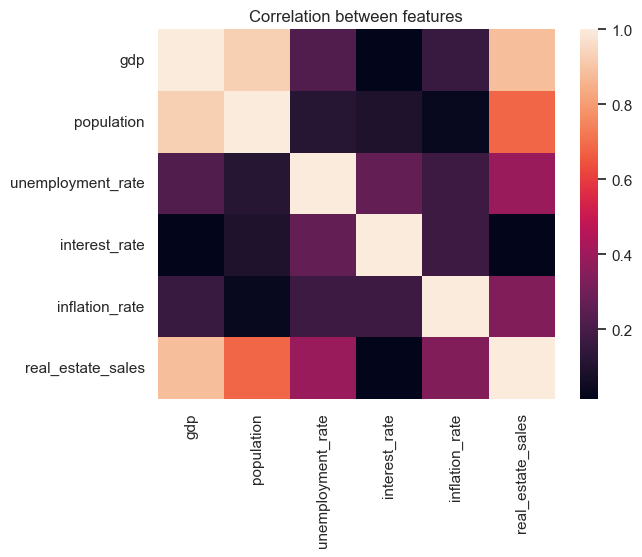

In [14]:
sns.heatmap(df[features].corr() ** 2)

plt.title('Correlation between features')
plt.savefig('images/correlation_heatmap.png', dpi=500, bbox_inches='tight')

It seems many cross correlations exist, so PCA may be a viable option. We will save the current data frame as is and then apply PCA.

### PCA

In [78]:
# read in data

x = pd.read_csv('data/features_scaled.csv')
y = pd.read_csv('data/target_scaled.csv')
x_new = pd.read_csv('data/test_data_scaled.csv')

from sklearn.decomposition import PCA

n = 4
t = PCA(n_components=n)

res = pd.DataFrame(t.fit_transform(x), columns=[f'Component {i}' for i in range(1, n + 1)])

print(t.explained_variance_)

[38.13916522  2.18972171  0.64574193  0.27333441]


From the explained variance, we will only use the first two as the others may add noise to the data.

### Adding Previous Amounts

As a sanity check, I also wanted to run an inference on including the previous year's total, almost like an auto-regression in time series (minus all the assumptions and technicalities).

I will also be omitting PCA from this, as it would be too much of a struggle.

In [27]:
df_without = pd.read_csv('data/features_scaled.csv').drop('Unnamed: 0', axis=1)

# standardize without new data
nrf_data_curr = nrf_data[:-1]

mu_y_tmp = np.mean(nrf_data_curr)
sigma_y_tmp = np.std(nrf_data_curr)

nrf_data_curr = (np.array(nrf_data_curr) - mu_y_tmp)/sigma_y_tmp

# add new data to dataframe
df_with = df_without.iloc[1:].reset_index(drop=True)

df_with['prev_year'] = nrf_data_curr

# add new data to test
test_with = pd.read_csv('data/test_data_scaled.csv').drop('Unnamed: 0', axis=1)

test_with['prev_year'] = ((nrf_data[-1] - mu_y_tmp) / sigma_y_tmp)

# save all dataframes

df_with.to_csv('data/features_scaled_with_prev.csv')
test_with.to_csv('data/test_data_scaled_with_prev.csv')

y_new = nrf_data[1:]

mu_y_new = np.mean(y_new)
sigma_y_new = np.std(y_new)

y_new = (np.array(y_new) - mu_y_new)/sigma_y_new

pd.DataFrame({'mu_y' : [mu_y_new], 'sigma_y' : [sigma_y_new]}).to_csv('data/y_new_distribution.csv')

pd.DataFrame({'spending' : y_new}).to_csv('data/target_scaled_with_prev.csv')

In [12]:
pd.DataFrame({'spending' : nrf_data}).to_csv('data/target_scaled_nontransformed.csv')